# Lab Week 2: NLP Example Usage and Stability

In this lab we will try out an NLP model and discuss some aspects of NLP models that will come up later in the course as well as your NLP projects. The use of `trulens` for visualization will be introduced. This notebook also demonstrates some of the text processing that might be useful for some NLP projects though we will not go over those details during the lab sessions. In the process we will investigate the bias of a sentiment model towards/against particular baseball teams; by the end of the first lab we should find tweets that have strangely differing sentiments according to a model of interest on tweets suchs as:

- "*redsox* are really playing"
- "*yankees* are really playing"

Students should be able to:

- realize that NLP models are easy to get and use, especially using `huggingface`,
- learn the structure of typical NLP pipelines,
- learn how to use `trulens` for visualization and attributions (next week), and
- use this notebook for ideas and/or coding tips when doing NLP projects.

You need to run this notebook with a "runtime" feature a GPU. You can "change runtime type" in the "Runtime" menu above. Evaluate the next few cells but their details do not need discussion. If you run into a CUDA out-of-memory error, you might have to restart the runtime. This notebook uses a particular branch of `trulens` which needs to be installed from `git+https://github.com/truera/trulens.git@piotrm/vis/output-detect` as is done below. Feedback from students can inform main branch trulens features so send thoughts to `piotrm@truera.com`.

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
# Some utilities to install things under colab. Run but ignore otherwise.

import sys
import subprocess
from pathlib import Path

# if running from within truera repo and want to use latest code, use this:
sys.path.insert(0, str(Path("../..").resolve()))

try: 
  import trulens
except: 
  !{sys.executable} -m pip install git+https://github.com/truera/trulens.git@piotrm/vis/output-detect

from trulens.utils.colab import install_if_not_installed, load_or_make

install_if_not_installed(["transformers", "pandas", "numpy", "domonic", "parmap"])

# Configure trulens
import os
os.environ['TRULENS_BACKEND']='torch'

from IPython.display import display
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import re

from torch.utils.data import DataLoader
from pandas import Series
from typing import Union
import parmap

transformers ... already installed
pandas ... already installed
numpy ... already installed
domonic ... already installed
parmap ... already installed


## Twitter Sentiment Model

[Huggingface](https://huggingface.co/models) offers a variety of pre-trained NLP models to explore. We exemplify in this notebook a [transformer-based twitter sentiment classification model](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment). This model scores each tweet with three scores: "negative", "neutral", or "positive" sentiment.

All it takes to download and instantiate a model from hugging face is these two lines:

```[python]
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)
```

The [pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines) interface can also be used to combine the two components, tokenizer and model, but in this lab we will be demonstrating the components so we will not use the pipeline.

The other elements instantiated in the below cell indicate deployment of the model to a GPU and some annotations around the labels to use for the model's classification scores.

In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

# Wrap all of the necessary components.
class TwitterSentiment:
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

    # device = 'cpu'
    # Can also use cuda if available:
    device = 'cuda:0'

    model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)

    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    @staticmethod
    def tokenize(inputs):
        return TwitterSentiment \
            .tokenizer(inputs, padding=True, return_tensors="pt") \
            .to(TwitterSentiment.device)
        # pt refers to pytorch tensor

    labels = ['negative', 'neutral', 'positive']

    NEGATIVE = labels.index('negative')
    NEUTRAL = labels.index('neutral')
    POSITIVE = labels.index('positive')

task = TwitterSentiment()

This model quantifies tweets (or really any text you give it) according to its sentiment: positive, negative, or neutral. Lets try it out on some examples.

In [10]:
sentences = ["I'm so happy!", "I'm so sad!", "I cannot tell whether I should be happy or sad!", "meh"]

# Input sentences need to be tokenized first.

inputs = task.tokenize(sentences)

# The tokenizer gives us vocabulary indexes for each input token (in this case,
# words and some word parts like the "'m" part of "I'm" are tokens).

print(inputs)

# Decode helps inspecting the tokenization produced:

print(task.tokenizer.batch_decode(torch.flatten(inputs['input_ids'])))
# Normally decode would give us a single string for each sentence but we would
# not be able to see some of the non-word tokens there. Flattening first gives
# us a string for each input_id.

{'input_ids': tensor([[   0,  100,  437,   98, 1372,  328,    2,    1,    1,    1,    1,    1,
            1],
        [   0,  100,  437,   98, 5074,  328,    2,    1,    1,    1,    1,    1,
            1],
        [   0,  100, 1395, 1137,  549,   38,  197,   28, 1372,   50, 5074,  328,
            2],
        [   0, 1794,  298,    2,    1,    1,    1,    1,    1,    1,    1,    1,
            1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')}
['<s>', 'I', "'m", ' so', ' happy', '!', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<s>', 'I', "'m", ' so', ' sad', '!', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<s>', 'I', ' cannot', ' tell', ' whether', ' I', ' should', ' be', ' happy', ' or', ' sad', '!', '</s>', '<s>', 'me', 'h', '</s>', '<pad>', '<

Some things to note:

- To evaluate a model, we first need to "tokenize" a text into indexed tokens, the *tokenization*. We should see the tokens in the example sentences inside the first `tensor` shown in the output above.

- While the token ids are not easy for us to inspect, we can use the tokenizer's `decode` method to invert the tokenization while keeping the token boundaries.

- Some words may get split into multiple tokens and structures like contractions also make use of multiple tokens.

- The tokenization includes special tokens such as seperator and padding tokens. Each text gets surrounded by "s" and "/s" tokens and each is padding with "pad" tokens so as to make each text of the same length.

- You can ignore the "attention_mask" component of the tokenizer output for now.



## Displaying tokens using *trulens*

The trulens library features some utilities for displaying tokenizations in a more readable manner. To use these, we use the `NLP` object as below. We need to configure it with regards to labels and a tokenizer's decode and encode methods.

In [11]:
from trulens.visualizations import NLP

V = NLP(
    labels=task.labels,
    decode=lambda x: task.tokenizer.decode(x),
    tokenize=task.tokenize,
    # huggingface models can take as input the keyword args as per produced by their tokenizers.

    input_accessor=lambda x: x['input_ids'],
    # for huggingface models, input/token ids are under input_ids key in the input dictionary

    hidden_tokens=set([task.tokenizer.pad_token_id])
    # do not display these tokens
)

V.tokens(sentences)#, show_id=True))

The underlines here span each separate token and we use the `hidden_tokens` argument to not render the padding tokens.

## Evaluating the model

Evaluating huggingface models is straight-forward if we use the structure (dictionary) produced by the tokenizer.

In [12]:
outputs = task.model(**inputs)

print(outputs)

# From logits we can extract the most likely class for each sentence and its readable label.

predictions = [task.labels[i] for i in outputs.logits.argmax(axis=1)]

for sentence, logits, prediction in zip(sentences, outputs.logits, predictions):
    print(logits.to('cpu').detach().numpy(), prediction, sentence)

SequenceClassifierOutput(loss=None, logits=tensor([[-2.3217, -0.8768,  4.0710],
        [ 2.5739, -0.4017, -2.1467],
        [ 0.5975,  0.3778, -0.7691],
        [-0.2266,  0.6009, -0.2009]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
[-2.3217494 -0.8767669  4.071023 ] positive I'm so happy!
[ 2.57388   -0.4016831 -2.1467047] negative I'm so sad!
[ 0.5975013   0.37778223 -0.7691222 ] negative I cannot tell whether I should be happy or sad!
[-0.2265977  0.6009302 -0.2008718] neutral meh


Things to discuss here:

- The actual inputs to the model are the contents of the tokenizer output dictionary which is primarily the `input_ids` tensor with integer indices into some vocabulary, one for each token. The inputs are thus discrete, integer, non-floating values. What does this imply regarding the explanation techniques we could deploy here?

- The output scores are "logits", they are not normalized. 

Trulens can also help us view these results in a more readable manner. But first we need to tell it about the model by wrappig it in a libray specific container:

In [13]:
from trulens.nn.models import get_model_wrapper

task.wrapper = get_model_wrapper(task.model, input_shape=(None, task.tokenizer.model_max_length), device=task.device)

INFO: lib level=1
INFO: root level=30
INFO: Detected pytorch backend for <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>.
INFO: Using backend Backend.PYTORCH.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.
DEBUG: Input dtype was not passed in. Defaulting to `torch.float32`.


We also need to indicate how to retrieve the logits from the output of the model as in the `output_accessor` parameter below:

In [14]:
V = NLP(
    wrapper=task.wrapper,
    labels=task.labels,
    decode=lambda x: task.tokenizer.decode(x),
    tokenize=task.tokenize,
    # huggingface models can take as input the keyword args as per produced by their tokenizers.

    input_accessor=lambda x: x['input_ids'],
    # for huggingface models, input/token ids are under input_ids key in the input dictionary

    output_accessor=lambda x: x['logits'],
    # and logits under 'logits' key in the output dictionary

    hidden_tokens=set([task.tokenizer.pad_token_id])
    # do not display these tokens
)

display(V.tokens(sentences, show_id=True))

The `show_id` argument lets us display the token indices alongside the human-readable form. Additionally, if a model `wrapper` is provided to the visualizer, the score visualization on the left of each text is will be shown. The scores visualized are normalized to "probits" if they are not already.

## Exploring real-world tweets

Lets try out the sentiment model on some real-world tweets. We first load it the CSV file to a pandas `DataFrame`.

In [15]:
# Only needed if dataset not already present.

def download_tweets(filename):
  subprocess.call(
      ["wget", "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"]
  )
  subprocess.call(
      ["unzip", "trainingandtestdata.zip"]
  )

tweets = load_or_make(
    filename=Path("training.1600000.processed.noemoticon.csv"),
    loader=lambda filename: pd.read_csv(filename, encoding='ISO-8859-1', header=None, names=["polarity", "id", "timestamp", "query", "user", "text"]),
    downloader=download_tweets
)

tweets

loading training.1600000.processed.noemoticon.csv ... from file


,polarity,id,timestamp,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


Lets take a look at the model's predictions on some of these tweets. Note that emojis were stripped from the dataset. These missing tokens are shown as �.

In [16]:
some_tweets = list(tweets['text'][0:10])

display(V.tokens(some_tweets))

Lets explore tweets that mention baseball teams. Below we have some utilities that find tweets that contain team names and create team-less versions of them where the team name is replaced with `:team:`. We can use such tweets to investigate the sensitivity of the sentiment model towards particular teams.

The processing here might be useful for students taking on NLP projects. No need to discuss during the lab.

In [17]:
def to_team(team: str):
    """Replaces all instances of ':team:' with the given `team` in the given list of tweets."""

    def f(tweets: Union[Series, np.ndarray]):
        if isinstance(tweets, pd.Series):
            return tweets.map(subst(":team:", team))
        if isinstance(tweets, np.ndarray):
            return np.vectorize(subst(":team:", team))(tweets)
        raise ValueError("I don't know")
    return f

def word_pattern(word):
    """Create a pattern that matches the given `word` as long as it is not immediately next to an alpha-numeric character."""
    return "(?<!\w)" + re.escape(word) + "(?!\w)"

def subst(thing_from: str, thing_to: str):
    pat = re.compile(word_pattern(thing_from), re.IGNORECASE)
    def f(context: str):
        return pat.sub(thing_to, context)
    return f

def contains(s, reg):
    return reg.search(s) is not None

def extract_teams(teams):
    """Create a method that extracts tweets that contain mentions of any of the terms in the given `teams`."""

    pattern = "(?<!\w)(" + '|'.join(map(re.escape, teams)) + ")(?!\w)"
    reg = re.compile(pattern, re.IGNORECASE)

    def f(tweets: Series):
        indices = np.array(parmap.map(contains, tweets.to_numpy(), reg))

        ret = tweets[indices]

        for team in teams:
            ret = ret.map(subst(team, ":team:"))

        return ret

    return f

This cell may take a minute to run. 

In [18]:
team_tweets = load_or_make(
    filename=Path("team_tweets.csv"),
    loader=lambda filename: pd.read_csv(filename, encoding='ISO-8859-1')['text'],
    maker=lambda: extract_teams([
        "diamondbacks", "braves", "orioles", "redsox", "red sox", "cubs", "whitesox", "white sox", "reds", 
        "guardians", "rockies", "tigers", "astros", "royals", "dodgers", "marlins", "brewers", "twins", 
        "mets", "yankees", "athletics", "phillies", "pirates", "padres", "giants", "mariners", "cardinals", 
        "rays", "rangers", "jays", "nationals"
      ]
       # ['redsox', 'red sox', 'yankees'],
      )(tweets['text']),
    saver = lambda filename, series: series.to_frame(name="text").to_csv(filename)
)

print(f"found {len(team_tweets)} team tweets")

for tweet in team_tweets[0:10]:
  print(tweet)

loading team_tweets.csv ... from file
found 2742 team tweets
A bad nite for the favorite teams: :team: and Spartans lose.  The nite out with T.W. was good.
Why oh why was the :team: game rained out? I was so looking forward to opening day 
YAY FOR BASEBALL SEASON! boo to :team: losing their first game 
@MissCassandra StiLL on my &quot;Lions &amp; :team: &amp; Bears&quot; shyt.............  but GOD is gOOd consequently, I wiLL be tOO
going to walk my dogs and shower before bed.   sad the :team: lost the first game monday too!  boooo 
READY FOR FRIDAY at the TED!! Go :team:! &amp; stocking up on ricola cough drops &amp; dayquil b.c i have a cold from the constant weather change 
ughh can't find my :team: hat, gotta wear this creepy nick pirro version 
No :team: opening game for me.  Conflicts will prevent me from going to the rescheduled game.
Noooooo the :team: beat the :team: 10-5  need to get to bmore to see derek jeter!!!!
@jutecht btw...loved your baseball post...this is definitely 

Lets now focus on two particular teams and compare the sentiment model on them. We start by creating versions of the team tweets with a particular team filled in to where the `:team:` marker was. We can visualize pairs of such tweets that differ in team via another trulens utility.

In [19]:
teams = ['redsox', 'yankees']
tweets_for_team = {team: to_team(team)(team_tweets) for team in teams}

display(V.tokens_stability(
    texts1=list(tweets_for_team[teams[0]][0:10]),
    texts2=list(tweets_for_team[teams[1]][0:10])
))

Lets inspect the distribution of logits accross tweets of the two teams.

Skip the details of this cell can during the lab.

In [20]:
# First a method to help us evaluate the model on a large collection of instances.
def eval_batched(data: Series, batch_size=128):
    """Evaluate the model `task.model` on given `data` tokenized by
    `task.tokenizer` in a set of batches. Return the logits."""

    # Might need to cleanup GPU ram:
    torch.cuda.empty_cache()

    sentences = DataLoader(data.to_numpy(), batch_size=batch_size)

    all_logits = []

    for batch in sentences:
        tokens = task.tokenizer(batch, padding=True, return_tensors='pt').to(task.device)
        logits = task.model(**tokens)['logits'].detach().to('cpu')
        del tokens
        all_logits += logits

    returning = np.stack(list(map(torch.Tensor.numpy, all_logits)))

    # Might need to cleanup GPU ram:
    torch.cuda.empty_cache()

    return returning

# Then get the logits for each team variant's tweets.
logits_for_team = {team: eval_batched(tweets) for team, tweets in tweets_for_team.items()}

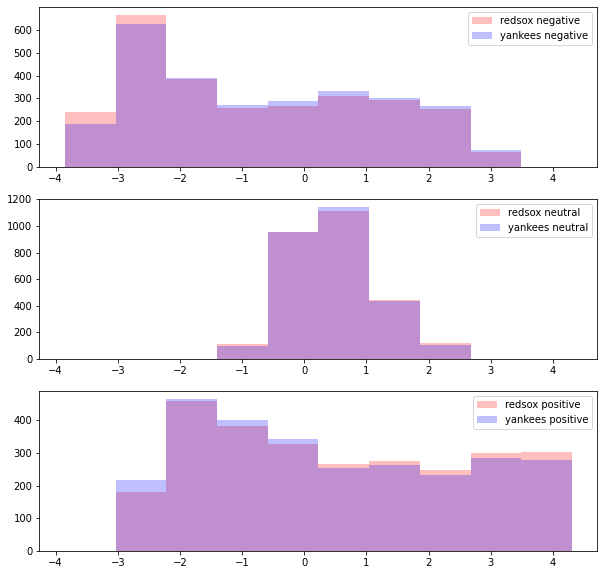

In [21]:
amin = min(logits.min() for logits in logits_for_team.values())
amax = max(logits.max() for logits in logits_for_team.values())

colors = {teams[0]: 'red', teams[1]: 'blue'}

# Create a figure showing the histogram of logits for each of the three classes for all of the teams in `teams`.

fig, axs = plt.subplots(3,1, figsize=(10,10))
for idx, label in zip([task.NEGATIVE,task.NEUTRAL,task.POSITIVE], task.labels):
    for team, logits in logits_for_team.items():
        axs[idx].hist(logits[:, idx], bins=10, alpha=0.25, label=f"{team} {label}", color=colors[team], range=(amin, amax))
    axs[idx].legend()

We should see that there are minor differences in the score distributions for the sentiments across the two teams, "redsox" and "yankees".

Are there any individual tweets that have particularly disparate logits? We can use `argsort` to get relevant indices into the lists of tweets.

In [22]:
# Get the index of tweets sorted by absolute difference in logits across teams.
sort_idx = np.argsort(abs(logits_for_team[teams[0]] - logits_for_team[teams[1]]).sum(axis=1))[::-1]

Trulens also provides a side-by-side rendering of texts with scores for exactly the situation of inspecting instabilities like the one we found.

In [23]:
team_tweets_np = team_tweets.to_numpy()

V.tokens_stability(
    texts1 = list(tweets_for_team[teams[0]].to_numpy()[sort_idx[0:10]]),
    texts2 = list(tweets_for_team[teams[1]].to_numpy()[sort_idx[0:10]])
)

# Lab Week 3: NLP Attribution

This week we will go over how to use trulens for computing gradient-based attributions for the NLP model covered last week. We will also cover several elements of tuning such attributions that may be relevant to particular use-cases. Specifically we will learn about:

- How to determine the embedding layer of a model. This will be needed for applying attributions to NLP as per the lecture on "Gradients in Explanations".
- Basics of using trulens to retrieve attributions.
- Distributions of interest.
- Quantities of interest.
- How to construct baselines for integrated gradients for NLP.

In [24]:
from trulens.nn.quantities import ClassQoI
from trulens.nn.attribution import IntegratedGradients, InputAttribution
from trulens.nn.attribution import Cut, OutputCut
from trulens.nn.distributions import GaussianDoi

## Attributions

Applying integrated gradents to the sentiment model is similar to non-NLP cases except special considerations need to be made for the cuts used as the targets of the attribution (i.e. what do we want to assign importance to). As you may have noted above, the model takes as input integer indexes associated with tokens. As we cannot take gradient with respect to these, we use an alternative: the embedding representation of those same inputs. To instantiate trulens with this regard, we need to find inspect the layer names inside our model:

In [25]:
task.wrapper.print_layer_names()

'roberta_embeddings_word_embeddings':	Embedding(50265, 768, padding_idx=1)
'roberta_embeddings_position_embeddings':	Embedding(514, 768, padding_idx=1)
'roberta_embeddings_token_type_embeddings':	Embedding(1, 768)
'roberta_embeddings_LayerNorm':	LayerNorm((768,), eps=1e-05, elementwise_affine=True)
'roberta_embeddings_dropout':	Dropout(p=0.1, inplace=False)
'roberta_encoder_layer_0_attention_self_query':	Linear(in_features=768, out_features=768, bias=True)
'roberta_encoder_layer_0_attention_self_key':	Linear(in_features=768, out_features=768, bias=True)
'roberta_encoder_layer_0_attention_self_value':	Linear(in_features=768, out_features=768, bias=True)
'roberta_encoder_layer_0_attention_self_dropout':	Dropout(p=0.1, inplace=False)
'roberta_encoder_layer_0_attention_output_dense':	Linear(in_features=768, out_features=768, bias=True)
'roberta_encoder_layer_0_attention_output_LayerNorm':	LayerNorm((768,), eps=1e-05, elementwise_affine=True)
'roberta_encoder_layer_0_attention_output_dropou

### Parameters

Above, `roberta_embeddings_word_embeddings` is the layer that produces a continuous representation of each input token so we will use that layer as the one defining the **distribution of interest**. While most neural NLP models contain a token embedding, the layer name will differ.

The second thing to note is the form of model outputs. Specifically, outputs are structures which contain a 'logits' attribute that stores the model scores.

Putting these things together, we instantiate `InputAttribution` to attribute each embedding dimension to the maximum of logit outputs.

In [26]:
# By default, the quantity of interest is max over logits. We need to, however, provide the means of accessing logits from the model 
# outputs via the accessor parameter:

infl_max = InputAttribution(
    model = task.wrapper,
    doi='point',
    doi_cut=Cut('roberta_embeddings_word_embeddings'),
    # qoi='max', # this is the default
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)

Getting attributions uses the same call as model evaluation.

In [27]:
sentence_attributions = infl_max.attributions(**inputs)

for token_ids, attribution in zip(inputs['input_ids'], sentence_attributions):

    for token_id, embedding_attribution in zip(token_ids, attribution):
        # Note that each `word_attr` has a magnitude for each of the embedding
        # dimensions, of which there are many. We aggregate them for easier
        # interpretation and display. You can uncomment the below line to see
        # the raw per-dimension attributions.
    
        #  print(embedding_attribution)

        attr = embedding_attribution.sum()

        word = task.tokenizer.decode(token_id)

        print(f"{word}({attr:0.3f})", end=' ')

    print()

<s>(0.002) I(0.004) 'm(0.003)  so(-0.003)  happy(-0.009) !(0.014) </s>(-0.001) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) 
<s>(-0.025) I(0.022) 'm(-0.024)  so(-0.006)  sad(-0.084) !(-0.033) </s>(-0.012) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) 
<s>(-0.026) I(0.037)  cannot(0.015)  tell(-0.095)  whether(-0.023)  I(-0.033)  should(0.003)  be(-0.027)  happy(-0.032)  or(-0.034)  sad(-0.037) !(-0.057) </s>(-0.003) 
<s>(-0.010) me(0.012) h(0.040) </s>(0.010) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) 


A listing as above is not very readable so Trulens comes with some utilities to present token influences a bit more concisely. The setup is the same as was last week.

In [28]:
V = NLP(
    wrapper=task.wrapper,
    labels=task.labels,
    decode=lambda x: task.tokenizer.decode(x),
    tokenize=task.tokenize,
    # huggingface models can take as input the keyword args as per produced by their tokenizers.

    input_accessor=lambda x: x['input_ids'],
    # for huggingface models, input/token ids are under input_ids key in the input dictionary

    output_accessor=lambda x: x['logits'],
    # and logits under 'logits' key in the output dictionary

    hidden_tokens=set([task.tokenizer.pad_token_id])
    # do not display these tokens
)

display(
    V.tokens(sentences, attributor=infl_max)
)

Attributions are, by default, indicated by color and colored bars above (positive) and below (negative) each token. There seems to be barely any attribution shown. Lets take a look at some of the tweets from the real-world dataset.

In [29]:
display(
    V.tokens(list(tweets_for_team[teams[0]][0:10]), attributor=infl_max)
)

## Distributions of interest

The attribution above does not seem very enlightening. Part of the issue is that the "point" distribution of interest is equivalent to a simple saliency, or just the gradient of the quantity of interest with respect to model inputs (or embeddings in this case). Using trulens, we have some better options to chose from:

- `PointDoi` - saliency as just described.
- `GaussianDoi` - averages out the gradients in the viscinity of the explained point with. The viscinity is sampled from a guassian distribution.
- `LinearDoi` - averages the gradients for inputs spanning a baseline interpolating all the way to the explained points. This is equivalent to Integrated Gradients.
- custom - you can also specify your own distribution of interest by subclassing any of the above or the `trulens.nn.distributions.DoI` class.

Lets try these out.

In [30]:
from trulens.nn.distributions import PointDoi, GaussianDoi, LinearDoi

attr_cut = Cut('roberta_embeddings_word_embeddings')

# Each doi needs to be told about the layer we are attributing to.
common_args = dict(cut=attr_cut)

dois = [
    PointDoi(**common_args),
    GaussianDoi(var=0.01, resolution=10, **common_args), # resolution is the number of samples to take
    LinearDoi(resolution=20, **common_args) # same
]

for doi in dois:
    print(doi)

    infl = InputAttribution(
        model = task.wrapper,
        doi=doi,
        doi_cut=attr_cut,
        qoi=ClassQoI(task.POSITIVE),
        qoi_cut=OutputCut(accessor=lambda o: o['logits'])
    )
    display(
        V.tokens(list(tweets_for_team[teams[0]][0:3]), attributor=infl)
    )

PointDoi(_cut=Cut(name=roberta_embeddings_word_embeddings,accessor=None,anchor=out))


GaussianDoi(_cut=Cut(name=roberta_embeddings_word_embeddings,accessor=None,anchor=out),_var=0.01,_resolution=10)


LinearDoi(_cut=Cut(name=roberta_embeddings_word_embeddings,accessor=None,anchor=out),_baseline=None,_resolution=20)


Ingore the other parameters of the printed DoI we did not discuss, they will not play a role for us in these labs. Note, however, the various differences in the attributions produced. Which of these attributions seems most accurate to what you think should be happening for classifying sentiment?

## Quantities of interest

The other main parameter to tune in attributions is the quantity being explained. Above we used the logits of the predicted class but instead we have several options:

- `MaxClassQoI` - as just noted,
- `ClassQoI` - logits of a specific class,
- `ComparativeQoI` - logits of one specific class minus logits of another,
- `LambdaQoI` - anything else definable from model outputs.

In [32]:
from trulens.nn.quantities import MaxClassQoI, ClassQoI, ComparativeQoI, LambdaQoI

attr_cut = Cut('roberta_embeddings_word_embeddings')

# Each doi needs to be told about the layer we are attributing to.
common_args = dict(cut=attr_cut)

doi = LinearDoi(resolution=20, **common_args)

# For a custom qoi, lets create one that gets the highest logit and outputs only
# its value. There are subtle differences between this and 'max' which we will
# not get into and one thing that trulens presently does not give us access to
# in these custom QoIs is the prediction of the instance being explained. While
# we use argmax here, it applies to instances produced by the distribution of
# interest which may or may not have a prediction matching the instance being
# explained.
def custom_qoi(logits):
    preds = logits.argmax(axis=1, keepdims=True)
    predicted_logits = logits.gather(1, preds)
    return predicted_logits.sum() # adding up over the entire batch

qois = [
    MaxClassQoI(),
    ClassQoI(task.POSITIVE),
    LambdaQoI(custom_qoi),
    ClassQoI(task.NEGATIVE),
    ComparativeQoI(task.POSITIVE, task.NEGATIVE),
]

for qoi in qois:
    print(qoi)

    infl = InputAttribution(
        model = task.wrapper,
        doi=doi,
        doi_cut=attr_cut,
        qoi=qoi,
        qoi_cut=OutputCut(accessor=lambda o: o['logits'])
    )

    display(
        V.tokens(list(tweets_for_team[teams[0]][0:3]), attributor=infl)
    )

MaxClassQoI(_axis=1,activation=None)


ClassQoI(cl=2)


LambdaQoI()


ClassQoI(cl=0)


ComparativeQoI(cl1=2,cl2=0)


## Baselines

We see in the above results that special tokens such as the sentence end **&lt;/s&gt;** contributes are found to contribute a lot to the model outputs. While this may be useful in some contexts, we are more interested in the contributions of the actual words in these sentences. To focus on the words more, we need to adjust the **baseline** used in the integrated gradients computation. By default in the instantiation so far, the baseline for each token is a zero vector of the same shape as its embedding. Special tokens, however, do not have zero embeddings. Lets take a look at pad and the sentence tokens.

In [33]:
print("padding token=", task.tokenizer.pad_token_id)
print("beginning of sentence token=", task.tokenizer.bos_token_id)
print("end of sentence token=", task.tokenizer.eos_token_id)

tokens = torch.tensor([task.tokenizer.bos_token_id, task.tokenizer.pad_token_id, task.tokenizer.eos_token_id]).to(task.device)

embeddings = task.model.get_input_embeddings()(tokens).detach().cpu().numpy()

print("magnitudes=", np.linalg.norm(embeddings, axis=1, ord=2))

padding token= 1
beginning of sentence token= 0
end of sentence token= 2
magnitudes= [3.0253851 2.5652604 2.3966749]


We see that these tokens, by their magnitudes, not close to the zero vector. By comparison, here are the magnitudes of the tokens making up the sample sentences we worked with at the beginning of the labs:

In [34]:
embeddings = task.model.get_input_embeddings()(inputs['input_ids']).detach().cpu().numpy()

print("magnitudes=", np.linalg.norm(embeddings, axis=2, ord=2))

magnitudes= [[3.0253851 2.354798  2.7147887 2.6391525 2.8347456 2.4811077 2.3966749
  2.5652604 2.5652604 2.5652604 2.5652604 2.5652604 2.5652604]
 [3.0253851 2.354798  2.7147887 2.6391525 2.77643   2.4811077 2.3966749
  2.5652604 2.5652604 2.5652604 2.5652604 2.5652604 2.5652604]
 [3.0253851 2.354798  2.8151646 2.7920527 2.924036  2.4636288 2.6795313
  2.5213802 2.8347456 2.6183937 2.77643   2.4811077 2.3966749]
 [3.0253851 3.3279371 3.0944285 2.3966749 2.5652604 2.5652604 2.5652604
  2.5652604 2.5652604 2.5652604 2.5652604 2.5652604 2.5652604]]


By making the basaeline be identicaly to the explained instances on special tokens, we can rid their impact from our measurement. Trulens provides a utility for this purpose in terms of `token_baseline` which constructs for you the methods to compute the appropriate baseline. 

In [35]:
from trulens.utils.nlp import token_baseline

inputs_baseline_ids, inputs_baseline_embeddings = token_baseline(
    keep_tokens=set([task.tokenizer.cls_token_id, task.tokenizer.bos_token_id, task.tokenizer.eos_token_id]),
    # Which tokens to preserve.

    replacement_token=task.tokenizer.pad_token_id,
    # What to replace tokens with.

    input_accessor=lambda x: x.kwargs['input_ids'],

    ids_to_embeddings=task.model.get_input_embeddings()
    # Callable to produce embeddings from token ids.
)

We can now inspect the baselines on some example sentences. The first method returned by `token_baseline` gives us token ids to inspect while the second gives us the embeddings of the baseline which we will pass to the attributions method.

In [36]:
from trulens.utils.typing import ModelInputs

print("originals=", task.tokenizer.batch_decode(inputs['input_ids']))

baseline_word_ids = inputs_baseline_ids(model_inputs=ModelInputs(kwargs=inputs))
print("baselines=", task.tokenizer.batch_decode(baseline_word_ids))

baseline_embeddings = inputs_baseline_embeddings(model_inputs=ModelInputs(kwargs=inputs))
# These are not useful to print.
# print("embeddings=", baseline_embeddings)

originals= ["<s>I'm so happy!</s><pad><pad><pad><pad><pad><pad>", "<s>I'm so sad!</s><pad><pad><pad><pad><pad><pad>", '<s>I cannot tell whether I should be happy or sad!</s>', '<s>meh</s><pad><pad><pad><pad><pad><pad><pad><pad><pad>']
baselines= ['<s><pad><pad><pad><pad><pad></s><pad><pad><pad><pad><pad><pad>', '<s><pad><pad><pad><pad><pad></s><pad><pad><pad><pad><pad><pad>', '<s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad></s>', '<s><pad><pad></s><pad><pad><pad><pad><pad><pad><pad><pad><pad>']


Note that special tokens are not replaced in the baseline while actual content words are replaced with "pad". Lets try some attributions again on these baselines.

In [37]:
infl_positive_baseline = IntegratedGradients(
    model = task.wrapper,
    resolution=20,
    baseline = inputs_baseline_embeddings,
    doi_cut=Cut('roberta_embeddings_word_embeddings'),
    qoi=ClassQoI(task.POSITIVE),
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)

print("QOI = POSITIVE WITH BASELINE")
V.tokens(list(tweets_for_team[teams[0]][0:10]), attributor=infl_positive_baseline)

QOI = POSITIVE WITH BASELINE


As we see, the baseline eliminated the measurement of contribution of the special tokens.

# Lab Week 4: Embeddings, Baselines, Paths


In [38]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from fastTSNE import TSNE
from fastTSNE.callbacks import ErrorLogger
import matplotlib.pyplot as plt
from IPython import display
from sklearn.decomposition import PCA
import numpy as np

# ! pip install jupyter ipywidgets ipympl mpld3
# ! pip install tsnecuda
# ! pip install tsnecuda==3.0.1+cu113 -f https://tsnecuda.isx.ai/tsnecuda_stable.html
# from sklearn.manifold import TSNE
# from tsnecuda import TSNE

# %matplotlib ipympl
# import mpld3
# mpld3.enable_notebook()

# Wrap all of the necessary components.
class TwitterSentiment:
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

    # device = 'cpu'
    # Can also use cuda if available:
    device = 'cuda:0'

    model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)

    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    @staticmethod
    def tokenize(inputs):
        return TwitterSentiment \
            .tokenizer(inputs, padding=True, return_tensors="pt") \
            .to(TwitterSentiment.device)
        # pt refers to pytorch tensor

    labels = ['negative', 'neutral', 'positive']

    NEGATIVE = labels.index('negative')
    NEUTRAL = labels.index('neutral')
    POSITIVE = labels.index('positive')

task = TwitterSentiment()
embedder = task.model.roberta.embeddings.word_embeddings
embeddings = embedder.weight.detach().cpu().numpy()

In [39]:
def closest_token(embeddings, emb):
    diffs = embeddings - emb
    # print(diffs.shape)
    distances = np.linalg.norm(diffs, ord=2, axis=1)
    # print(distances.shape)
    closest = np.argsort(distances)
    # print(closest.shape)
    return closest[0], distances[closest[0]]

In [40]:
idx, dist = closest_token(embeddings, np.zeros(768))

In [41]:
print(task.tokenizer.decode(idx), dist)

<unk> 1.6685961165969307


In [42]:
from trulens.nn.distributions import PointDoi, GaussianDoi, LinearDoi
from trulens.utils.typing import ModelInputs

In [43]:
sample_inputs = task.tokenizer("I'm so happy!", return_tensors='pt').to("cuda")
sample_ids = sample_inputs['input_ids'].cuda()[0]
sample_embs = embedder(sample_ids.cuda())

In [44]:
print(sample_ids.shape)
print(sample_embs.shape)

torch.Size([7])
torch.Size([7, 768])


In [51]:
from trulens.utils.nlp import token_baseline

inputs_baseline_ids, inputs_baseline_embeddings = token_baseline(
    keep_tokens=set([task.tokenizer.cls_token_id, task.tokenizer.bos_token_id, task.tokenizer.eos_token_id]),
    # Which tokens to preserve.

    replacement_token=task.tokenizer.pad_token_id,
    # What to replace tokens with.

    input_accessor=lambda x: x.kwargs['input_ids'],
    # input_accessor = lambda x: x, 

    ids_to_embeddings=task.model.get_input_embeddings()
    # Callable to produce embeddings from token ids.
)

# path = LinearDoi(resolution=11, baseline=inputs_baseline_embeddings)(sample_embs, model_inputs=ModelInputs(args=[], kwargs=sample_inputs))
path = GaussianDoi(resolution=11, var=0.25)(sample_embs)#, model_inputs=ModelInputs(args=[], kwargs=sample_inputs))

In [73]:
for i in range(len(path)):
    for word_idx in range(len(sample_ids)):
        word_emb = sample_embs[word_idx]
        word_id = sample_ids[word_idx]
        word_token = task.tokenizer.decode(word_id)

        interv_emb = path[i][word_idx]
        # interv_emb = path[i][0][word_idx]
        close_id, close_dist = closest_token(embeddings, interv_emb.cpu().detach().numpy())
        # print(close_id)
        close_emb = embeddings[close_id]
        close_token = task.tokenizer.decode(close_id)

        print(close_token, end=' ')
    
    print()

        # print(word_emb[0:2], word_id, word_token, close_emb[0:2], close_id, close_token, close_dist, interv_emb[0:2])

<s>  her 'm  so  happy  electronic </s> 
<s> I 'm  SO  happy ! </s> 
<s> I 'm  so  happy !  hunting 
<s> I 'm  so  happy ! </s> 
<s> I 'm  so  happy ! </s> 
<s> I  am  so  happy !" </s> 
<s> I  43  so  happy ! </s> 
<s> I 'm  so twitter ! </s> 
<s> I 'm  so  happy  attached </s> 
<s> I 'm  so  happy ! </s> 
<s>  Corner 'm  so  happy ! </s> 


In [ ]:
pca = PCA(n_components=10)
pca.fit(embeddings)

In [ ]:
emb_reduced = pca.transform(embeddings)

In [ ]:
%matplotlib ipympl
plt.ion()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

errors = []

def showme(iteration, error, embedding):
    ax.clear()
    # ax.scatter(embedding[:,0], embedding[:,1], s=0.5, m=',')
    ax.scatter(embedding[:,0], embedding[:,1], s=1.0, marker='.', alpha=0.5)

    errors.append(error)

    # ax[1].clear()
    # ax[1].plot(errors)

    fig.canvas.draw()
    fig.canvas.flush_events()

In [ ]:
tsne = TSNE(n_components=2, n_jobs=-1, n_iter=100, callbacks=showme, callbacks_every_iters=10, neighbors='exact', negative_gradient_method='fft')

emb = tsne.prepare_initial(emb_reduced[0:2000])

tsne.callbacks = [showme]

In [ ]:
emb = emb.optimize(n_iter=1000)

In [ ]:
toks = [task.tokenizer.decode(i, clean_up_tokenization_spaces=True).replace(" ", "_") for i in range(len(emb))]

annots = []

for i, e in enumerate(emb):
    tok = toks[i]
    if len(annots) <= i:
        annots.append(ax.annotate(tok, xy=e, alpha=0.5))#, fontsize=1)
    else:
        annots[i].xy = e
    # print(i, e, tok)

In [ ]:
emb.transform()

In [ ]:
fig.canvas.draw()
fig.canvas.flush_events()

In [ ]:
import numpy as np
def map_to_2d(embs):
    embs_pca = pca.transform(embs)
    embs_2d = emb.transform(embs_pca)
    return embs_2d

# map_to_2d(np.zeros((1, 768)))

In [ ]:
emin = embeddings.min()
emax = embeddings.max()

axxs = np.zeros((101,768))

axxs[:,0] = np.linspace(emin, emax, 101)

In [ ]:
axis_in_2d = map_to_2d(axxs)

In [ ]:
ax.plot(axis_in_2d[:,0], axis_in_2d[:,1])

In [ ]:
! export LD_LIBRARY_PATH=/usr/local/cuda-11/lib64
import os, sys

print(os.environ['LD_LIBRARY_PATH'])

import tsnecuda
tsnecuda.test()

In [ ]:
fig.show()

In [ ]:
import umap
u = umap.UMAP()

In [ ]:
u.fit(emb_reduced)

In [ ]:
u.embedding_

In [ ]:
plt.scatter(u.embedding_[:,0], u.embedding_[:,1], s=1, marker='.')